
# 神经网实现      手写识别体的多分类


上篇博文，忽略偏置(b)，且代价(损失)函数直接就是差的平方和，本篇文章增加了对偏置的讨论，本文是本人的学习笔记，如果出现问题，欢迎大家批评指正。

需具备知识：

- 二元函数的偏导数的求解和意义
- 链式法则求导


## 数据集的下载

使用以下git命令克隆：


```
git clone https://github.com/mnielsen/neural-networks-and-deep-learning.git
```

该数据集分为：

- 60000 幅训练图像
- 10000 幅测试图像

我们把 60000幅训练图像再划分为：
- 50000 幅训练集
- 10000 幅验证集

使用验证集有助于我们设置神经网络的某些**超参数**，例如学习率（lr）等。


### 定义神经网络代码的核心片段

假如定义最简单的3层神经网络，```sizes = [2, 3, 1]```,则：

偏置的维度：(3, 1) <br/>
权重的维度：(3, 2), (1, 3)

以下定义的 类 Network 中的偏置bias 和权重weights 都是随机变化的，值为0~1之间的正态分布数。

假如我们实例化对象：
```python
    net = Network()
```

**注：**
-  np.random.randn() 生成的是均值为0，标准差为1的高斯分布(正态分布)。
-  第一层神经元是一个输入层，不对其设置任何偏置，因为偏置在后面的层中用于计算输出。
-  偏置和矩阵以 NumPy 矩阵列表的形式存储。例如：net.weights[1] : 第2层和第3层神经元之间的权重。

我们使用 $ \omega $ 表示矩阵， $ \omega_{jk} $ 表示第2层的k个神经元，第3层的j个神经元的权重。

这样写有点绕，目的是为了计算 权重 和 输入层变量进行 点乘，即：

$$
    a^{\prime} = \sigma(\omega \cdot a + b)
$$

以上例子， $\omega$ 是 第2、3层的权重激活向量， a 是第二次神经元的**激活向量**(可以理解为权重\*输入+偏置之后经过激活函数)，

$ \sigma() $ 函数是 **激活函数**sigmoid函数，定义如下：

$$
    sigmoid = \frac{1}{1+e^{-x}} 
$$

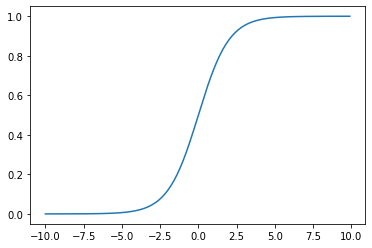

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1.0/(1.0+np.exp(-x))  

x = np.arange(-10, 10, 0.1)
y = sigmoid(x)
plt.plot(x, y)
plt.show()


In [2]:
import numpy as np
import pandas as pd

class Network(object):
    '''
        sizes ： 各层神经元的个数
    '''
    def __init__(self, sizes:list):
        
        self.num_layers = len(sizes)                                 # 神经元的层数
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]      # 偏置 b
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]
    pass

Network([2, 3, 1])

In [3]:
sizes = [2, 3, 1]
biases = [np.random.randn(y, 1) for y in sizes[1:]]
biases   # 偏置

[array([[0.42305446],
        [0.09270809],
        [1.37065137]]),
 array([[-0.60325518]])]

In [4]:
weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])] # 权重
weights

[array([[-0.85328277, -0.65275394],
        [-1.23824422, -0.83507403],
        [-0.36639638, -1.57123581]]),
 array([[-0.11760388, -0.96681311,  0.49207488]])]

In [5]:
[np.zeros(b.shape) for b in biases]

[array([[0.],
        [0.],
        [0.]]),
 array([[0.]])]

### 前向传播

该方法和我上一个博文中mnist的多分类预测中，写的 query() 是相同的功能实现。



In [6]:
def feedforward(self, a):
    """若 a 为输入，则返回输出
        注：a 为 上一个节点的激活输出，如果为第一个节点，则是输入层的神经元个数，维度为 (n_variable, 1) 的NumPy ndarray数组，而不是
        (n_variable,)的向量，这样写的目的是便于计算机计算，也便于修改代码实现同时前馈多个输入。
        并且，CPU 一次只传入一个样本进行训练，右边的 1 代表一个样本。
        
    """
    for b, w in zip(self.biases, self.weights):
        a = sigmoid(np.dot(w, a) + self.biases)  # z = w*x+b  a = sigmoid(z)
    return a

### 梯度下降算法


#### 随机梯度下降算法

这里我们使用**随机梯度下降算法**

#### 代价函数

公式如下：

$$
    z = w \cdot x + b \tag{1}
$$

$$
    a = \sigma(z) \tag{2}
$$

$$
    C(w, b) \equiv \frac{1}{2n}\sum_x \left||y(x)-a\right||^2 \tag{3}
$$

$$
    \sigma(z) = \frac{1}{1+e^{-z}} \tag{4}
$$

sigma 函数 是激活函数的一种，本文激活函数选择的是sigmoid函数，Python实现如下：

```
def sigmoid(x):
    return 1.0/(1.0+np.exp(-x))
```

公式解释： 
- 公式1中 w 是**权重**， b是**偏置**，x 表示的是样本，一般维度为(n_varible, 1)，如果是CPU一次训练1个样本，z是激活函数的输入；

注意，这里 x 是一个训练样本，不是变量，w, b 才是变量。
    
     
- 公式2中， 激活函数的输入是 公式1中的结果 z, 通过激活函数得到的结果是 a。

注意：a(z) = sigmoid(z) a 是 z 的函数，z 是 w、x的函数，进而，a也是 w、x的函数。

- 公式3， 叫做 **代价函数**，也叫*损失函数*或者目标函数，本文叫该函数为代价函数。该公式称为

**二次代价函数** 也称 **均方误差(MSE)**， y(x) 表示 x (x是常量)样本的真实值， $a$ 表示 a 表示 通过权重、偏置、激活函数之后的输

出，如果是最后一层，即是预测值，如果是中间层即是每个神经元通过激活函数的输出值。

- 公式4是 sigmoid 函数，比较简单，不再解释。


刚开始训练时，误差比较大，即 y(x) 和 $a$ 相差较大， 我们的目的是最小化 代价函数 C(w, b),换句话说：我们想找到 让代价函数尽可能小的

权重和偏置，这该怎么实现哪？

我们往下看：

我们定义
$$
       \nabla C = \big(\frac{\partial C}{\partial w}, \frac{\partial C}{\partial b} \big)^T \tag{5}
$$    

$$
    w^{\prime} = w - \eta \frac{\partial C}{\partial w}  \tag{6}
$$

$$
    b^{\prime} = b - \eta \frac{\partial C}{\partial b}  \tag{7}
$$

假如 $v=(w, b)$ 表示变量 v 有2个变量，分别是 w, b。则

$$
  v^{\prime} = v - \eta \nabla C \tag{8}
$$

解释：
- 公式5，只是把 C 对变量 w 和 b的偏导数 变成一个矩阵形式， **偏导数**$\Delta w = \frac{\partial C}{\partial w} \Delta b = \frac{\partial C}{\partial b}$

**表示C相对于w的变化率**。

- 公式6，**梯度下降公式**， 左边表示新的权重值，右边表示 旧的权重值 - 学习率 乘 **变化率**, $\eta$ 表示**学习率**。

字母可以随便改变，不同书籍使用的不一样，只要能够理解就可以。

问题：如果找到 合适的**权重和偏置** 使得 **代价函数** 最小？？？

我们使用 **梯度下降算法和反向传播算法**来解决这个问题，其中，梯度下降算法是为了找到代价函数的最小值，使用梯度下降公式，一步一步更新

权重和偏置，最重要的就是求代价函数的**偏导数**, 这是我们使用 **反向传播算法** 从最后一层神经元的**激活向量**$a(z(w, b))$，依次求

出前一层的神经元的**误差**, 因为更新 每一层的 权重和偏置时，需要用到 每一层的激活向量值$a(z(w, b))$。公式如下：

- 反向传播:对每个l = L-1,L-2,...2
$$
    \delta^{x, l} = ((w_{l+1}^T\delta^{x, l+1}) * \sigma^{\partial}(z^{x,l}) )  \tag{9}   
$$

- 梯度下降：对每个l = L, L-1, L-2, ..., 2,根据

$$
    w^{l} -> \frac{\eta}{m} \sum  _{x} \delta^{x, l}(a^{x,l-1})^T \tag{10}
$$


和 

$$
    b^{l} -> b^l - \frac{\eta}{m}\sum_x \delta^{x, l} \tag{11}
$$

#### 疑问：什么是梯度？什么是误差？什么是偏导数？

以下公式直接是推导出来的答案，如果感兴趣的话，具体如何推导的可以查看相关机器学习类的书籍或者网上的资料。


误差的定义：
    $$
        \delta = \frac{\partial C}{\partial z}
    $$
    
注：z 表示激活函数的输入。

推论：

- 最后一层误差的求解：

$$
    \delta = \frac{\partial C}{\partial a} * \partial^{'}(z) = (W_{后}^T \cdot \delta) * \partial^{'}(z)
$$
    
- C对b的偏导数：

$$
    \frac{\partial C}{\partial b} = \delta
$$

- C 对 w 的偏导数：

$$
    \frac{\partial C}{\partial w} = \delta * a_{前}^T
$$

#### 梯度下降算法的实现：

对于每个训练样本：

- 前向传播
- 输出误差 : 
        
 最后一层 的误差求解为 (a - y(x)) *sigmoid的导数 。
 
- 反向传播误差

 倒数第二层的误差，使用最后一层的误差求解,依次类推。

梯度下降：

$$
    w_{new} = w_{old} - \frac{\eta}{m} \frac{\partial C}{\partial w}
$$

$$
    b_{new} = b_{old} - \frac{\eta}{m} \frac{\partial C}{\partial b}
$$

In [ ]:
# 梯度下降：

    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None):
        """ SGD : stochastic gradient descent
            training_data : 训练集，传入 zip() 对象， 使用 list() 后数据变为：[((784, 1), (10, 1)), ...]
            epochs : 训练轮数
            mini_batch_size : 批大小，每次训练的小样本批次大小
            eta : 学习率
            test_data : 可选参数， 对于追踪训练结果是有用的，但是会拖慢训练速度
        """
        training_data = list(training_data)       # 把 zip() 对象 ==> list [((784, 1), (10, 1)), ...]
        n = len(training_data)                    # 训练集样本个数

        if test_data:
            test_data = list(test_data)
            n_test = len(test_data)               # 测试集样本的长度

        for j in range(epochs):
            random.shuffle(training_data)         # 打乱(训练集)列表元素顺序
            # [[((784, 1), (10, 1)), ..., ], [mini_batch_size个],...]
            mini_batchs = [training_data[k:k+mini_batch_size] for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batchs:
                self.update_mini_batch(mini_batch, eta)

            if test_data:
                print(f"Epoch {j}:{self.evaluate(test_data)} / {n_test}")
            else:
                print(f"Epoch {j} completed.")
        pass

#### 反向传播代码

In [ ]:
    def backprop(self, x, y):
        """
            x : (784, 1) , ndarray 对象
            y : (10, 1) , ndarray 对象
            返回元组(nabla_b, nable_w) 代表成本/代价/损失函数 C_x 的 梯度(偏C/偏b, 偏C/偏w)。
            ([(30, 1), (10, 1)], [(30, 784), (10, 30)])

            前面注释可知公式：
            输出误差  delta = 偏C/偏a * sigma 的导数
            偏C/偏w = 误差delta · 前一层的激活层 a 的转秩
        """
        nabla_b = [np.zeros(b.shape) for b in self.biases]  # [(30， 1), (10， 1)]     存放偏置的误差 偏C/偏b
        nabla_w = [np.zeros(w.shape) for w in self.weights]  # [(30, 784), [10, 30]]   存放权重的误差 偏C/偏w

        # 前向传播
        activation = x      # 激活值
        activations = [x]   # [(784, 1)] , list 列表 ： 存放所有的激活值,其中 a = sigmoid(z)

        zs = []  # list 存放每层的 z 向量（激活函数的输入值）， 其中 z = w · x + b [(30, 1), (10, 1)]
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward 反向传播
        delta = self.cost_derivative(activations[-1], y) * sigmoid_prime(zs[-1]) # 求最后一层的误差 delta = 偏C/偏a * sigma 的导数
        nabla_b[-1] = delta                          # 偏C/偏b
        # print(f"C/w:{delta.shape}, a前.shape:{activations[-2].shape}", )
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())  # 偏C/偏w = 误差delta · 前一层的激活层 a 的转秩

        """
            前面已经求出了最后一层的 偏C/偏b 和 偏C/偏w
            从倒数第二层开始往前遍历到 正数第二层
        """
        for l in range(2, self.num_layers):
            z = zs[-l]              # 第一次遍历时，l = 2 ,表示倒数第二层 的激活函数的输入 z 向量
            sp = sigmoid_prime(z)   # 激活函数的倒数
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp     # delta = 后一层的w · 后一层的delta * 当前层的激活函数的倒数
            nabla_b[-l] = delta        # 误差、梯度、偏导数
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())     # 偏C/偏w = 误差delta · 前一层的激活层 a 的转秩
        return (nabla_b, nabla_w)


In [ ]:
import random

training_data = np.arange(6).reshape(6,)
training_data

In [ ]:
random.shuffle(training_data)
training_data

In [ ]:
seq = [1, 2, 3, 4, 5]
random.shuffle(seq)
seq

## 数据集的处理

- 解压 .gz 的压缩包
- 把数据集分为训练集、验证集、测试集


In [11]:
# .gz 的压缩包 使用 gzip() 函数进行解压

import gzip
import pickle  # 块 pickle 实现了对一个 Python 对象结构的二进制序列化和反序列化

f = gzip.open(r'..\mnist.pkl.gz')         # 返回 gzip.GzipFile 对象

# training_data : ((50000, 784), (50000,)) 元组：2个元素，都是 NumPy对象， 维度如前所示
# validation_data : ((10000, 784), (10000,))
# test_data : ((10000, 784), (10000,))
training_data, validation_data, test_data = pickle.load(f, encoding='latin1') # 从已打开的 file object 文件 中读取封存后的对象，重建其中特定对象的层次结构并返回。
f.close()

In [12]:
# 调整 training_data 的格式/维度， 方便训练
import numpy as np

# （5000， 784） 每一条(784,) 训练数据 转换成 (784, 1)的二维数据，存放到 list 中。
training_input = [np.reshape(x, (784, 1)) for x in training_data[0]]  
training_input[0].shape, training_input[1].shape

# data = np.arange(50).reshape(10, 5)
# data = data[:2, :]
# [np.reshape(x, (5, 1)) for x in data]

((784, 1), (784, 1))

In [13]:
def vectorized_result(label):
    e = np.zeros((10, 1))
    e[label] = 1.0
    return e


training_data[0].shape, training_data[1].shape # ((50000, 784), (50000,))
# 我们要把 training_data[1] 的每个标签 转化为神经网络期望的输出 每个标签都是(10, 1)的ndarray数组
print(training_data[1][:2])
[vectorized_result(x) for x in training_data[1][:2]]

[5 0]


[array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.]]),
 array([[1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])]

In [14]:
training_inputs = [np.reshape(x, (784, 1)) for x in training_data[0][:2, :]]
training_results = [vectorized_result(y) for y in training_data[1][:2]]

training_data = zip(training_inputs, training_results)


In [15]:
type(training_data)

zip

In [18]:
for X, y in training_data:
    print(x.shape)
    print(y.shape)
    

In [20]:
[k for k in range(0, 10, 3)]

[0, 3, 6, 9]

In [23]:
a = [1, 2, 3, 4 ,5]
a[2:10]

[3, 4, 5]

In [34]:
import numpy as np

a = np.array([0, 10, 2, 6])
a
np.argmax(a)

1

In [42]:
sum([1, 8, 2])

11

$\delta$

In [43]:
for i in range(2, 3):
    print(i)

2


In [48]:
mini_batch_size = 5
training_data = [i for i in range(20)]
n = len(training_data)
print(training_data)
mini_batch_size = [training_data[k:k+mini_batch_size] for k in range(0, n, mini_batch_size)]
mini_batch_size


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


[[0, 1, 2, 3, 4], [5, 6, 7, 8, 9], [10, 11, 12, 13, 14], [15, 16, 17, 18, 19]]

In [67]:
x = np.random.rand(10, 1)
# [x]

In [68]:
x

array([[0.15858945],
       [0.43174131],
       [0.67859285],
       [0.8891154 ],
       [0.50479713],
       [0.24900165],
       [0.5631615 ],
       [0.62361639],
       [0.17701574],
       [0.50959991]])

In [69]:
x.transpose() # 转秩

array([[0.15858945, 0.43174131, 0.67859285, 0.8891154 , 0.50479713,
        0.24900165, 0.5631615 , 0.62361639, 0.17701574, 0.50959991]])

In [71]:
for i in range(3):
    print(i)
    
i += 10
print(i)

0
1
2
12


In [76]:
2+1 * \
10

12

In [77]:
## 所有代码

network.py

In [ ]:
import numpy as np
import pandas as pd
import random


class Network(object):
    '''
        sizes ： 各层神经元的个数
    '''
    def __init__(self, sizes :list):

        self.num_layers = len(sizes)                                  # 神经元的层数
        self.biases = [np.random.randn(y, 1)
                       for y in sizes[1:]]      # 偏置 b
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]  # 权重

    # 前馈传播
    def feedforward(self, a):
        """
            如果 a 是输入，则返回神经网络的输出。
            假如初始化为 3层的神经网络：[784, 30, 10]， 则：
            w = [(30, 784), (10, 30)]
            b = [(30, 1), (10, 1)]
            第一层时， a 的输入为 (784, 1), a 即是 激活层：通过激活函数得到的值，第一层时为样本输入。
            计算：
            第2层 : w · a + b :  (30, 784) · (784, 1) + (30, 1) ==> (30, 1)
            第3层 : w · a + b :  (10, 30) · (30, 1) + (10, 1)   ==> (10, 1)
        """
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a) + b)       # z = w · x + b   a = sigmoid(a)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None):
        """ SGD : stochastic gradient descent
            training_data : 训练集，传入 zip() 对象， 使用 list() 后数据变为：[((784, 1), (10, 1)), ...]
            epochs : 训练轮数
            mini_batch_size : 批大小，每次训练的小样本批次大小
            eta : 学习率
            test_data : 可选参数， 对于追踪训练结果是有用的，但是会拖慢训练速度
        """
        training_data = list(training_data)       # 把 zip() 对象 ==> list [((784, 1), (10, 1)), ...]
        n = len(training_data)                    # 训练集样本个数

        if test_data:
            test_data = list(test_data)
            n_test = len(test_data)               # 测试集样本的长度

        for j in range(epochs):
            random.shuffle(training_data)         # 打乱(训练集)列表元素顺序
            # [[((784, 1), (10, 1)), ..., ], [mini_batch_size个],...]
            mini_batchs = [training_data[k:k+mini_batch_size] for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batchs:
                self.update_mini_batch(mini_batch, eta)

            if test_data:
                print(f"Epoch {j}:{self.evaluate(test_data)} / {n_test}")
            else:
                print(f"Epoch {j} completed.")
        pass

    def update_mini_batch(self, mini_batch, eta):
        """使用梯度下降法和反向传播更新 mini_batch 的权重和偏置。
        mini_batch 类型如下： [((784, 1), (10, 1)), ...] 有 mini_batch_size 个样本(元组)
        eta : 学习率
        这两个算法比较复杂，梯度下降算法和反向传播算法的使用都是根据理论推导出的公式实现的，因此，我们只需要记住最后推导得出的公式进行实现即可。
        反向传步骤：
        对于每个样本 x：设置对应的激活值 a, 执行步骤如下：
            1.前向传播(feedforward): z = w · x + b , a = sigma(z)
            2.求输出误差: 从最后一层开始算起， 输出误差  delta = 偏C/偏a * sigma 的导数， 偏C/偏w = 前一层的a · 当前层的delta
            3.反向传播误差 ：从倒数第二层开始，到 正数第二场为止， 计算
                误差 倒数第二层的delta = w(最后后一层) · delta(最后一层的) * sigmoid的导数

        梯度下降步骤：对每个神经网络层， w_new = w_old - eta · delta · a^T
                                   b_new = b_old - eta * delta
        神经元成熟 和 每层神经元个数 ：[784, 30, 10]
        """
        nabla_b = [np.zeros(b.shape) for b in self.biases]    # [(30， 1), (10， 1)]
        nable_w = [np.zeros(w.shape) for w in self.weights]   # [(30, 784), [10, 30]]
        for x, y in mini_batch:
            # delta_nabla_b : (10, 1), delta_nable_w : (10, 30)
            delta_nabla_b, delta_nable_w = self.backprop(x, y)              # 反向传播由最后一层得到当前层的 偏置和权重的误差
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]   # b+delta b
            nable_w = [nw + dnw for nw, dnw in zip(nable_w, delta_nable_w)] # w + delta w [(30, 784), (10, 30)]
        self.weights = [w - (eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nable_w)] # w = w - eta/m * 偏C/偏w
        self.biases = [b - (eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]   # b = b-eta/m * 偏C/偏b
        pass

    def backprop(self, x, y):
        """
            x : (784, 1) , ndarray 对象
            y : (10, 1) , ndarray 对象
            返回元组(nabla_b, nable_w) 代表成本/代价/损失函数 C_x 的 梯度(偏C/偏b, 偏C/偏w)。
            ([(30, 1), (10, 1)], [(30, 784), (10, 30)])

            前面注释可知公式：
            输出误差  delta = 偏C/偏a * sigma 的导数
            偏C/偏w = 误差delta · 前一层的激活层 a 的转秩
        """
        nabla_b = [np.zeros(b.shape) for b in self.biases]  # [(30， 1), (10， 1)]     存放偏置的误差 偏C/偏b
        nabla_w = [np.zeros(w.shape) for w in self.weights]  # [(30, 784), [10, 30]]   存放权重的误差 偏C/偏w

        # 前向传播
        activation = x      # 激活值
        activations = [x]   # [(784, 1)] , list 列表 ： 存放所有的激活值,其中 a = sigmoid(z)

        zs = []  # list 存放每层的 z 向量（激活函数的输入值）， 其中 z = w · x + b [(30, 1), (10, 1)]
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward 反向传播
        delta = self.cost_derivative(activations[-1], y) * sigmoid_prime(zs[-1]) # 求最后一层的误差 delta = 偏C/偏a * sigma 的导数
        nabla_b[-1] = delta                          # 偏C/偏b
        # print(f"C/w:{delta.shape}, a前.shape:{activations[-2].shape}", )
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())  # 偏C/偏w = 误差delta · 前一层的激活层 a 的转秩

        """
            前面已经求出了最后一层的 偏C/偏b 和 偏C/偏w
            从倒数第二层开始往前遍历到 正数第二层
        """
        for l in range(2, self.num_layers):
            z = zs[-l]              # 第一次遍历时，l = 2 ,表示倒数第二层 的激活函数的输入 z 向量
            sp = sigmoid_prime(z)   # 激活函数的倒数
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp     # delta = 后一层的w · 后一层的delta * 当前层的激活函数的倒数
            nabla_b[-l] = delta        # 误差、梯度、偏导数
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())     # 偏C/偏w = 误差delta · 前一层的激活层 a 的转秩
        return (nabla_b, nabla_w)


    def evaluate(self, test_data):
        test_results = [(np.argmax(self.feedforward(x)), y) for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations:np.ndarray, y:np.ndarray):
        """返回输出层层的误差。公式为
            误差 delta = 偏C_x / 偏a = 每层的激活值 - 真实值
            output_activations : (10, 1) - (10, 1) numpy.ndarray 类型
        """
        return (output_activations - y)


def sigmoid(z):
    """激活函数：sigmoid"""
    return 1.0/(1.0 + np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function
        Sigmoid 函数的偏导数
        直接查资料得到偏导数结果，推导可查看相关书籍
    """
    return sigmoid(z) * (1-sigmoid(z))

test.py

In [ ]:
import network
import mnist_loader


nn = network.Network([2, 3, 2])         #  实例化对象

# 加载 .gz 数据集
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()
# 定义3层神经网络，每层神经元个数分别为 784, 30, 10
net = network.Network([784, 30, 10])

# training_data = list(training_data)

# [((784 1),(10, 1)), ((784 1),(10, 1)), ...]
# for X, y in training_data:
#     print(X.shape, y.shape)
#     nabla_b, nabla_w = net.backprop(X, y)
#     break

# for b, w in zip(nabla_b, nabla_w):
#     print(nabla_b[0].shape, nabla_w[0].shape)
#     break

# [((784 1), 标签), ((784 1), 标签), ...]
# test_data = list(test_data)
# for X, y in test_data:
#     print(X.shape, y.shape)
#     print(y)
#     break


# for w, b in zip(net.weights, net.biases):
#     print(w.shape, b.shape)
# net.SGD(training_data, 30, 10, 3.0, test_data=test_data)

# for X, y in training_data:
#     a = net.feedforward(X)
#     print(a)
#     break

net.SGD(training_data, epochs=30, mini_batch_size=10, eta=3.0, test_data=test_data)
